<a href="https://colab.research.google.com/github/LilyMimosa/Capstone-Project/blob/main/Capstone_SiDeJan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I. IMPORT

In [1]:
import kagglehub
import os
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score

import joblib

pd.set_option('display.max_columns', None)

II. FILE PATH

In [2]:
KAGGLE_DATASET_REPO = "kamilpytlak/personal-key-indicators-of-heart-disease"
KAGGLE_FILE_IN_REPO = "2022/heart_2022_with_nans.csv"

GDRIVE_PROJECT_DIR = '/content/drive/MyDrive/dicoding_capstone'

# DATASETS
GDRIVE_DATASETS_DIR = 'datasets'
GDRIVE_DATASETS_PATH = os.path.join(GDRIVE_PROJECT_DIR, GDRIVE_DATASETS_DIR)

# MODELS
GDRIVE_MODELS_DIR = 'models'
GDRIVE_MODEL_PATH = os.path.join(GDRIVE_PROJECT_DIR, GDRIVE_MODELS_DIR)

# Original dataset
GDRIVE_ORIGINAL_DATASET_FILE = '1.original.csv'
GDRIVE_ORIGINAL_FILE_PATH = os.path.join(GDRIVE_DATASETS_PATH, GDRIVE_ORIGINAL_DATASET_FILE)

# No duplicate dataset
GDRIVE_NO_DUPLICATE_DATASET_FILE = '2.no_duplicate.csv'
GDRIVE_NO_DUPLICATE_DATASET_PATH = os.path.join(GDRIVE_DATASETS_PATH, GDRIVE_NO_DUPLICATE_DATASET_FILE)

# No irrelevant
GDRIVE_NO_IRRELEVANT_DATASET_FILE = '3.no_irrelevant.csv'
GDRIVE_NO_IRRELEVANT_DATASET_PATH = os.path.join(GDRIVE_DATASETS_PATH, GDRIVE_NO_IRRELEVANT_DATASET_FILE)

# Fixed binary
GDRIVE_FIXED_BINARY_DATASET_FILE = '4.fixed_binary.csv'
GDRIVE_FIXED_BINARY_DATASET_PATH = os.path.join(GDRIVE_DATASETS_PATH, GDRIVE_FIXED_BINARY_DATASET_FILE)

# Fixed ordinal
GDRIVE_FIXED_ORDINAL_DATASET_FILE = '5.fixed_ordinal.csv'
GDRIVE_FIXED_ORDINAL_DATASET_PATH = os.path.join(GDRIVE_DATASETS_PATH, GDRIVE_FIXED_ORDINAL_DATASET_FILE)

# Fixed nominal
GDRIVE_FIXED_NOMINAL_DATASET_FILE = '6.fixed_nominal.csv'
GDRIVE_FIXED_NOMINAL_DATASET_PATH = os.path.join(GDRIVE_DATASETS_PATH, GDRIVE_FIXED_NOMINAL_DATASET_FILE)

# With target
GDRIVE_WITH_TARGET_DATASET_FILE = '7.with_target.csv'
GDRIVE_WITH_TARGET_FILE_PATH = os.path.join(GDRIVE_DATASETS_PATH, GDRIVE_WITH_TARGET_DATASET_FILE)

# Lowercase object
GDRIVE_LOWERCASE_OBJECT_DATASET_FILE = '8.lowercase_object.csv'
GDRIVE_LOWERCASE_OBJECT_DATASET_PATH = os.path.join(GDRIVE_DATASETS_PATH, GDRIVE_LOWERCASE_OBJECT_DATASET_FILE)

# Base preprocessed
GDRIVE_BASE_PREPROCESSED_DATASET_FILE = '9.base_preprocessed.csv'
GDRIVE_BASE_PREPROCESSED_DATASET_PATH = os.path.join(GDRIVE_DATASETS_PATH, GDRIVE_BASE_PREPROCESSED_DATASET_FILE)

# Distance based scaled
GDRIVE_DISTANCE_BASE_SCALED_DATASET_FILE = '10.distance_base_scaled.csv'
GDRIVE_DISTANCE_BASE_SCALED_DATASET_PATH = os.path.join(GDRIVE_DATASETS_PATH, GDRIVE_DISTANCE_BASE_SCALED_DATASET_FILE)

# Tree based scaled
GDRIVE_TREE_BASE_SCALED_DATASET_FILE = '11.tree_base_scaled.csv'
GDRIVE_TREE_BASE_SCALED_DATASET_PATH = os.path.join(GDRIVE_DATASETS_PATH, GDRIVE_TREE_BASE_SCALED_DATASET_FILE)

# **III. REUSABLE FUNCTIONS**

Dataframe summarization

In [3]:
def summarize_dataframe(df: pd.DataFrame):
    summary = pd.DataFrame({
        "Non-Null Count": df.notnull().sum(),
        "Null Count": df.isnull().sum(),
        "Dtype": df.dtypes,
        "Unique Values": df.nunique()
    })

    print(f"Dataset shape:")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

    print("\nSummary:")
    print(summary)

    print("\nType Count:")
    print(df.dtypes.value_counts())

    return summary

Dataframe unique values

In [4]:
def show_unique_values(df, max_display=40):
    for col in df.columns:
        uniques = df[col].unique()[:max_display]
        print(f"\nColumn: {col}")
        print(f"Unique values (max {max_display} shown): {uniques}")
        print(f"Total unique values: {df[col].nunique()}")

# **IV. DOWNLOAD ORIGINAL DATASET**

In [5]:
drive.mount('/content/drive', force_remount=True)

os.makedirs(GDRIVE_PROJECT_DIR, exist_ok=True)

if os.path.exists(GDRIVE_ORIGINAL_FILE_PATH):
    print(f"Original dataset found in Google Drive: {GDRIVE_ORIGINAL_FILE_PATH}")
    df = pd.read_csv(GDRIVE_ORIGINAL_FILE_PATH)
else:
    print("Downloading dataset from Kaggle")
    df = kagglehub.dataset_load(
      kagglehub.KaggleDatasetAdapter.PANDAS,
      KAGGLE_DATASET_REPO,
      KAGGLE_FILE_IN_REPO,
    )

    print(f"Saving to Google Drive: {GDRIVE_ORIGINAL_FILE_PATH}")
    os.makedirs(GDRIVE_DATASETS_PATH, exist_ok=True) # Add this line to create the directory
    df.to_csv(GDRIVE_ORIGINAL_FILE_PATH, index=False)

df.sample(n=10)

Mounted at /content/drive
Original dataset found in Google Drive: /content/drive/MyDrive/dicoding_capstone/datasets/1.original.csv


,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
148786,Maine,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,8.0,1 to 5,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,NaN,NaN,NaN,"White only, Non-Hispanic",Age 60 to 64,1.63,54.43,20.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173388,Massachusetts,Female,Good,0.0,0.0,Within past 2 years (1 year but less than 2 ye...,Yes,7.0,None of them,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"Other race only, Non-Hispanic",Age 25 to 29,1.60,NaN,NaN,Yes,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
399202,Washington,Female,Good,2.0,15.0,Within past 5 years (2 years but less than 5 y...,Yes,5.0,None of them,No,No,No,Yes,No,No,No,No,Yes,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"Other race only, Non-Hispanic",Age 35 to 39,1.68,NaN,NaN,No,No,Yes,No,NaN,No,No
286409,Ohio,Female,Very good,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,No,No,No,Yes,No,No,No,No,"Yes, but only during pregnancy (female)",Yes,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 40 to 44,1.73,113.40,38.01,No,Yes,Yes,No,"No, did not receive any tetanus shot in the pa...",No,No
387720,Virginia,Male,Good,7.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,All,No,No,No,No,No,Yes,No,No,Yes,No,No,No,No,Yes,No,No,Former smoker,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 75 to 79,1.78,88.45,27.98,Yes,Yes,Yes,Yes,"Yes, received Tdap",No,Yes
443481,Puerto Rico,Male,Good,0.0,0.0,Within past 5 years (2 years but less than 5 y...,No,7.0,None of them,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Not at all (right now),Yes,Hispanic,Age 30 to 34,1.68,68.04,24.21,Yes,Yes,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes
229494,Nebraska,Male,Good,0.0,0.0,Within past year (anytime less than 12 months ...,No,7.0,All,No,Yes,No,Yes,No,No,No,No,Yes,Yes,No,Yes,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 80 or older,1.78,88.00,27.84,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
33368,California,Male,Very good,0.0,0.0,Within past 5 years (2 years but less than 5 y...,Yes,8.0,None of them,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,Yes,Hispanic,Age 50 to 54,1.80,72.57,22.40,No,Yes,Yes,Yes,"Yes, received Tdap",No,No
342910,Tennessee,Female,Fair,12.0,5.0,Within past year (anytime less than 12 months ...,Yes,5.0,"6 or more, but not all",No,No,No,Yes,No,Yes,Yes,Yes,Yes,"No, pre-diabetes or borderline diabetes",No,No,Yes,Yes,No,Yes,Never smoked,Never used e-cigarettes in my entire life,Yes,"Black only, Non-Hispanic",Age 45 to 49,1.65,133.81,49.09,Yes,Yes,Yes,Yes,"Yes, received Tdap",No,No
161848,Maryland,Female,Excellent,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,8.0,"6 or more, but not all",No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 65 to 69,1.57,77.11,31.09,Yes,No,No,Yes,"Yes, received tetanus shot, but not Tdap",No,Yes


**Summarize dataset**

In [6]:
summarize_dataframe(df)

Dataset shape:
Rows: 445132, Columns: 40

Summary:
                           Non-Null Count  Null Count    Dtype  Unique Values
State                              445132           0   object             54
Sex                                445132           0   object              2
GeneralHealth                      443934        1198   object              5
PhysicalHealthDays                 434205       10927  float64             31
MentalHealthDays                   436065        9067  float64             31
LastCheckupTime                    436824        8308   object              4
PhysicalActivities                 444039        1093   object              2
SleepHours                         439679        5453  float64             24
RemovedTeeth                       433772       11360   object              4
HadHeartAttack                     442067        3065   object              2
HadAngina                          440727        4405   object              2
HadStroke    

,Non-Null Count,Null Count,Dtype,Unique Values
State,445132,0,object,54
Sex,445132,0,object,2
GeneralHealth,443934,1198,object,5
PhysicalHealthDays,434205,10927,float64,31
MentalHealthDays,436065,9067,float64,31
LastCheckupTime,436824,8308,object,4
PhysicalActivities,444039,1093,object,2
SleepHours,439679,5453,float64,24
RemovedTeeth,433772,11360,object,4
HadHeartAttack,442067,3065,object,2


**Show unique value**

In [7]:
show_unique_values(df)


Column: State
Unique values (max 40 shown): ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island']
Total unique values: 54

Column: Sex
Unique values (max 40 shown): ['Female' 'Male']
Total unique values: 2

Column: GeneralHealth
Unique values (max 40 shown): ['Very good' 'Excellent' 'Fair' 'Poor' 'Good' nan]
Total unique values: 5

Column: PhysicalHealthDays
Unique values (max 40 shown): [ 0.  2.  1.  8.  5. 30.  4. 23. 14. nan 15.  3. 10.  7. 25.  6. 21. 20.
 29. 16.  9. 27. 28. 12. 13. 11. 26. 17. 24. 19. 18. 22.]
Total unique values: 31

Column: MentalHealthDays
Unique va

# **1. DATA PREPARATION**

## **1.1 Load original dataset**

In [8]:
# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
if os.path.exists(GDRIVE_ORIGINAL_FILE_PATH):
    print(f"Loading from Google Drive: {GDRIVE_ORIGINAL_FILE_PATH}")
    df = pd.read_csv(GDRIVE_ORIGINAL_FILE_PATH)
else:
    print(f"Original dataset not found in Google Drive: {GDRIVE_ORIGINAL_FILE_PATH}\nRun Download Section")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading from Google Drive: /content/drive/MyDrive/dicoding_capstone/datasets/1.original.csv


**Sample**

In [9]:
df.sample(n=15)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
242234,New Hampshire,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,8.0,1 to 5,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Not at all (right now),NaN,"White only, Non-Hispanic",Age 55 to 59,1.65,56.70,20.80,Yes,No,Yes,No,NaN,No,No
376214,Vermont,Female,Fair,28.0,0.0,Within past year (anytime less than 12 months ...,No,12.0,"6 or more, but not all",No,No,No,Yes,No,No,No,No,Yes,Yes,No,No,No,Yes,No,Yes,Never smoked,Never used e-cigarettes in my entire life,NaN,"White only, Non-Hispanic",Age 50 to 54,NaN,NaN,NaN,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
342022,Tennessee,Male,Good,0.0,2.0,5 or more years ago,Yes,6.0,None of them,No,No,No,No,No,No,Yes,No,No,No,No,No,Yes,No,No,No,Former smoker,Use them every day,No,"White only, Non-Hispanic",Age 25 to 29,1.83,90.72,27.12,Yes,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
240055,New Hampshire,Male,Good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,1 to 5,Yes,Yes,No,No,Yes,No,No,No,Yes,No,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 70 to 74,1.78,74.84,23.67,No,NaN,Yes,Yes,NaN,No,No
166589,Maryland,Male,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,1 to 5,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never smoked,Never used e-cigarettes in my entire life,NaN,"White only, Non-Hispanic",Age 50 to 54,1.75,79.38,25.84,Yes,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,Yes
207088,Minnesota,Female,Good,0.0,0.0,Within past 2 years (1 year but less than 2 ye...,Yes,8.0,None of them,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,No,NaN,NaN,NaN,NaN,NaN,Yes,No,Yes,Yes,"Yes, received Tdap",No,No
23932,Arkansas,Male,Good,0.0,0.0,NaN,Yes,NaN,None of them,No,No,No,No,No,No,No,No,No,"No, pre-diabetes or borderline diabetes",No,No,No,No,No,No,Former smoker,Not at all (right now),No,"Black only, Non-Hispanic",Age 25 to 29,1.70,65.77,22.71,No,Yes,No,No,"No, did not receive any tetanus shot in the pa...",No,No
72903,Florida,Female,Good,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Yes,No,No,Never smoked,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 45 to 49,1.63,70.31,26.61,Yes,Yes,No,No,"Yes, received Tdap",No,Yes
373471,Vermont,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,Former smoker,Never used e-cigarettes in my entire life,No,"White only, Non-Hispanic",Age 65 to 69,1.75,81.65,26.58,No,No,Yes,No,"No, did not receive any tetanus shot in the pa...",No,No
138830,Louisiana,Male,Fair,30.0,30.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,No,No,No,No,No,Yes,No,No,No,No,Yes,No,Yes,No,No,Former smoker,Never used e-cigarettes in my entire life,Yes,"White only, Non-Hispanic",Age 75 to 79,1.80,88.45,27.20,Yes,No,Yes,NaN,NaN,No,No


**Summary**

In [10]:
summarize_dataframe(df)

Dataset shape:
Rows: 445132, Columns: 40

Summary:
                           Non-Null Count  Null Count    Dtype  Unique Values
State                              445132           0   object             54
Sex                                445132           0   object              2
GeneralHealth                      443934        1198   object              5
PhysicalHealthDays                 434205       10927  float64             31
MentalHealthDays                   436065        9067  float64             31
LastCheckupTime                    436824        8308   object              4
PhysicalActivities                 444039        1093   object              2
SleepHours                         439679        5453  float64             24
RemovedTeeth                       433772       11360   object              4
HadHeartAttack                     442067        3065   object              2
HadAngina                          440727        4405   object              2
HadStroke    

,Non-Null Count,Null Count,Dtype,Unique Values
State,445132,0,object,54
Sex,445132,0,object,2
GeneralHealth,443934,1198,object,5
PhysicalHealthDays,434205,10927,float64,31
MentalHealthDays,436065,9067,float64,31
LastCheckupTime,436824,8308,object,4
PhysicalActivities,444039,1093,object,2
SleepHours,439679,5453,float64,24
RemovedTeeth,433772,11360,object,4
HadHeartAttack,442067,3065,object,2


**Unique values**

In [11]:
show_unique_values(df)


Column: State
Unique values (max 40 shown): ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island']
Total unique values: 54

Column: Sex
Unique values (max 40 shown): ['Female' 'Male']
Total unique values: 2

Column: GeneralHealth
Unique values (max 40 shown): ['Very good' 'Excellent' 'Fair' 'Poor' 'Good' nan]
Total unique values: 5

Column: PhysicalHealthDays
Unique values (max 40 shown): [ 0.  2.  1.  8.  5. 30.  4. 23. 14. nan 15.  3. 10.  7. 25.  6. 21. 20.
 29. 16.  9. 27. 28. 12. 13. 11. 26. 17. 24. 19. 18. 22.]
Total unique values: 31

Column: MentalHealthDays
Unique va

## **1.2 Handle duplicate**

**Check for duplicate**

In [12]:
print(f"Duplicate rows:\n{df.duplicated().sum()}")

Duplicate rows:
157


**Drop Duplicates**

In [13]:
df_no_duplicate = df.copy()

df_no_duplicate = df_no_duplicate.drop_duplicates()
print(f"\nDuplicate columns after processing:\n{df_no_duplicate.duplicated().sum()}")

print(f"\nSaving to Google Drive: {GDRIVE_NO_DUPLICATE_DATASET_PATH}")
df_no_duplicate.to_csv(GDRIVE_NO_DUPLICATE_DATASET_PATH, index=False)


Duplicate columns after processing:
0

Saving to Google Drive: /content/drive/MyDrive/dicoding_capstone/datasets/2.no_duplicate.csv


## **1.3 Handle irrelevant feature**

Immediate drop irrelevant columns

Reason:

State: too many unique values and unreliable. Typically used only for mapping; any genetic-related factors (are already/can be) represented by RaceEthnicityCategory.
ChestScan: irrelevant. Based on the documentation, this question only asks whether the respondent has ever had a CT scan, serving merely as a gateway to more specific CT scan results.
HighRiskLastYear: redundant. This column is an input used to create HIVTesting Column.
LastCheckupTime: not so important

In [14]:
df_no_irrelevant = df_no_duplicate.copy()

df_no_irrelevant = df_no_irrelevant.drop(columns=["State", "ChestScan", "HighRiskLastYear", "LastCheckupTime"])

summarize_dataframe(df_no_irrelevant)

print(f"\nSaving to Google Drive: {GDRIVE_NO_IRRELEVANT_DATASET_PATH}")
df_no_irrelevant.to_csv(GDRIVE_NO_IRRELEVANT_DATASET_PATH, index=False)

Dataset shape:
Rows: 444975, Columns: 36

Summary:
                           Non-Null Count  Null Count    Dtype  Unique Values
Sex                                444975           0   object              2
GeneralHealth                      443782        1193   object              5
PhysicalHealthDays                 434053       10922  float64             31
MentalHealthDays                   435913        9062  float64             31
PhysicalActivities                 443887        1088   object              2
SleepHours                         439527        5448  float64             24
RemovedTeeth                       433620       11355   object              4
HadHeartAttack                     441915        3060   object              2
HadAngina                          440575        4400   object              2
HadStroke                          443423        1552   object              2
HadAsthma                          443207        1768   object              2
HadSkinCancer

## **1.4 Feature evaluation**

### **1.4.1 Binary**

**List of binary columns**

In [15]:
binary_cols = [
    'Sex',
    'PhysicalActivities',
    'HadAsthma',
    'HadSkinCancer',
    'HadCOPD',
    'HadDepressiveDisorder',
    'HadKidneyDisease',
    'HadArthritis',
    'DeafOrHardOfHearing',
    'BlindOrVisionDifficulty',
    'DifficultyConcentrating',
    'DifficultyWalking',
    'DifficultyDressingBathing',
    'DifficultyErrands',
    'ChestScan',
    'AlcoholDrinkers',
    'HIVTesting',
    'FluVaxLast12',
    'PneumoVaxEver',
]

**`Sex` is the only feature with different kind of value in the binary columns**

In [16]:
df_fixed_binary = df_no_irrelevant.copy()

df_fixed_binary = df_fixed_binary.rename(columns={'Sex': 'IsMale'})
df_fixed_binary['IsMale'] = df_fixed_binary['IsMale'].map({'Male': 'Yes', 'Female': 'No'})

index_to_replace = binary_cols.index('Sex')
binary_cols[index_to_replace] = 'IsMale'

show_unique_values(df_fixed_binary[['IsMale']])

print(f"\nSaving to Google Drive: {GDRIVE_FIXED_BINARY_DATASET_PATH}")

df_fixed_binary.to_csv(GDRIVE_FIXED_BINARY_DATASET_PATH, index=False)


Column: IsMale
Unique values (max 40 shown): ['No' 'Yes']
Total unique values: 2

Saving to Google Drive: /content/drive/MyDrive/dicoding_capstone/datasets/4.fixed_binary.csv


### **1.4.2 Ordinal**

**List of ordinal columns**

In [17]:
ordinal_cols = [
    'GeneralHealth',
    'RemovedTeeth',
    'SmokerStatus',
    'ECigaretteUsage',
    'AgeCategory'
]

**Values to change**

In [18]:
removed_teeth_map = {
    'None of them': 'none',
    '1 to 5': 'less then 6',
    '6 or more, but not all': 'more than 6, but not all',
    'All': 'all'
}

smoker_status_map = {
    'Never smoked': 'never',
    'Former smoker': 'used to',
    'Current smoker - now smokes some days': 'occasionally',
    'Current smoker - now smokes every day': 'daily'
}


ecigarette_usage_map = {
    'Never used e-cigarettes in my entire life': 'never',
    'Not at all (right now)': 'not currently',
    'Use them some days': 'occasionally',
    'Use them every day': 'daily'
}

age_category_map = {
    'Age 18 to 24': '18-24 years',
    'Age 25 to 29': '25-29 years',
    'Age 30 to 34': '30-34 years',
    'Age 35 to 39': '35-39 years',
    'Age 40 to 44': '40-44 years',
    'Age 45 to 49': '45-49 years',
    'Age 50 to 54': '50-54 years',
    'Age 55 to 59': '55-59 years',
    'Age 60 to 64': '60-64 years',
    'Age 65 to 69': '65-69 years',
    'Age 70 to 74': '70-74 years',
    'Age 75 to 79': '75-79 years',
    'Age 80 or older': '80+ years'
}

ordinal_maps = {
    'RemovedTeeth': removed_teeth_map,
    'SmokerStatus': smoker_status_map,
    'ECigaretteUsage': ecigarette_usage_map,
    'AgeCategory': age_category_map
}

df_fixed_ordinal = df_fixed_binary.copy()

for col, mapping in ordinal_maps.items():
    df_fixed_ordinal[col] = df_fixed_ordinal[col].map(mapping)

show_unique_values(df_fixed_ordinal[ordinal_cols])

df_fixed_ordinal.to_csv(GDRIVE_FIXED_ORDINAL_DATASET_PATH, index=False)


Column: GeneralHealth
Unique values (max 40 shown): ['Very good' 'Excellent' 'Fair' 'Poor' 'Good' nan]
Total unique values: 5

Column: RemovedTeeth
Unique values (max 40 shown): [nan 'none' 'less then 6' 'more than 6, but not all' 'all']
Total unique values: 4

Column: SmokerStatus
Unique values (max 40 shown): ['never' 'occasionally' 'used to' nan 'daily']
Total unique values: 4

Column: ECigaretteUsage
Unique values (max 40 shown): ['not currently' 'never' nan 'daily' 'occasionally']
Total unique values: 4

Column: AgeCategory
Unique values (max 40 shown): ['80+ years' '55-59 years' nan '40-44 years' '75-79 years' '70-74 years'
 '65-69 years' '60-64 years' '50-54 years' '45-49 years' '35-39 years'
 '25-29 years' '30-34 years' '18-24 years']
Total unique values: 13


### **1.4.3 Nominal**

**List of nominal columns**

In [19]:
nominal_cols = [
    'HadDiabetes',            # 4
    'RaceEthnicityCategory',  # 5
    'TetanusLast10Tdap',      # 4
    'CovidPos'                # 3
]

**Values to change**

In [20]:
diabetes_map = {
    'No': 'no',
    'Yes': 'yes',
    'No, pre-diabetes or borderline diabetes': 'borderline',
    'Yes, but only during pregnancy (female)': 'pregnancy only'
}

race_map = {
    'White only, Non-Hispanic': 'white',
    'Black only, Non-Hispanic': 'black',
    'Hispanic': 'hispanic',
    'Other race only, Non-Hispanic': 'other',
    'Multiracial, Non-Hispanic': 'multiracial'
}

tetanus_map = {
    'No, did not receive any tetanus shot in the past 10 years': 'no',
    'Yes, received Tdap': 'yes_tdap',
    'Yes, received tetanus shot, but not Tdap': 'yes_tetanus_only',
    'Yes, received tetanus shot but not sure what type': 'yes_unsure'
}

covid_map = {
    'No': 'no',
    'Yes': 'yes',
    'Tested positive using home test without a health professional': 'yes_home_test'
}

nominal_maps = {
    'HadDiabetes': diabetes_map,
    'RaceEthnicityCategory': race_map,
    'TetanusLast10Tdap': tetanus_map,
    'CovidPos': covid_map
}

df_fixed_nominal = df_fixed_ordinal.copy()

for col, mapping in nominal_maps.items():
    df_fixed_nominal[col] = df_fixed_nominal[col].map(mapping)

show_unique_values(df_fixed_nominal[nominal_cols])

df_fixed_nominal.to_csv(GDRIVE_FIXED_NOMINAL_DATASET_PATH, index=False)


Column: HadDiabetes
Unique values (max 40 shown): ['yes' 'no' 'borderline' nan 'pregnancy only']
Total unique values: 4

Column: RaceEthnicityCategory
Unique values (max 40 shown): ['white' 'black' 'other' 'multiracial' nan 'hispanic']
Total unique values: 5

Column: TetanusLast10Tdap
Unique values (max 40 shown): ['yes_unsure' 'no' nan 'yes_tdap' 'yes_tetanus_only']
Total unique values: 4

Column: CovidPos
Unique values (max 40 shown): ['no' 'yes' nan 'yes_home_test']
Total unique values: 3


In [21]:
df_fixed_nominal.sample(n=15)

,IsMale,GeneralHealth,PhysicalHealthDays,MentalHealthDays,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,CovidPos
234252,No,Very good,2.0,7.0,Yes,6.0,none,No,No,No,No,No,No,No,No,No,no,No,No,No,No,No,No,daily,never,white,35-39 years,1.70,83.91,28.97,Yes,Yes,Yes,No,yes_tdap,no
147552,No,Poor,30.0,0.0,No,8.0,"more than 6, but not all",No,No,No,No,No,No,No,No,No,pregnancy only,No,No,No,Yes,Yes,Yes,used to,never,white,80+ years,1.63,50.80,19.22,No,No,No,Yes,yes_tdap,no
90901,Yes,Excellent,0.0,2.0,Yes,6.0,"more than 6, but not all",No,No,No,No,No,No,No,No,No,no,No,No,Yes,No,No,No,used to,daily,multiracial,35-39 years,1.80,72.57,22.32,Yes,Yes,No,No,yes_unsure,yes
52594,Yes,Poor,30.0,0.0,No,8.0,all,Yes,Yes,No,Yes,No,Yes,No,No,NaN,no,No,No,No,Yes,Yes,No,occasionally,not currently,white,65-69 years,1.75,58.97,19.20,No,Yes,Yes,Yes,yes_unsure,no
432701,No,Good,30.0,10.0,No,7.0,all,Yes,Yes,No,No,No,No,No,No,Yes,no,Yes,No,Yes,Yes,No,No,used to,never,white,70-74 years,1.52,74.84,32.22,No,No,Yes,No,no,yes
281462,Yes,Good,0.0,5.0,Yes,9.0,less then 6,No,No,No,No,No,No,Yes,No,Yes,no,No,No,No,No,No,No,never,not currently,white,60-64 years,1.88,95.25,26.96,No,No,No,No,yes_unsure,no
401939,Yes,Very good,0.0,0.0,Yes,7.0,none,No,No,No,No,No,No,No,No,No,yes,No,No,No,No,No,No,never,never,white,60-64 years,1.88,99.79,28.25,Yes,No,Yes,No,yes_tetanus_only,no
383818,Yes,Good,0.0,0.0,Yes,7.0,less then 6,No,No,No,No,Yes,No,No,No,Yes,no,No,No,No,No,No,No,used to,never,white,80+ years,1.73,86.18,28.89,Yes,No,Yes,Yes,yes_unsure,yes_home_test
232157,Yes,Fair,10.0,15.0,Yes,10.0,less then 6,Yes,No,No,No,No,Yes,Yes,No,Yes,no,Yes,No,No,No,No,No,used to,never,white,60-64 years,1.70,113.40,39.16,No,Yes,Yes,Yes,no,yes
343132,No,Very good,5.0,5.0,Yes,8.0,none,No,No,No,No,No,No,Yes,No,Yes,no,No,Yes,No,No,No,No,never,never,white,75-79 years,1.57,63.50,25.61,No,No,Yes,Yes,yes_tetanus_only,no


### **1.4.4 Create target**

In [22]:
source_col = ['HadHeartAttack', 'HadAngina', 'HadStroke']

def categorize(row):
    conditions = []
    if str(row['HadHeartAttack']).lower() == "yes":
        conditions.append("HeartAttack")
    if str(row['HadAngina']).lower() == "yes":
        conditions.append("Angina")
    if str(row['HadStroke']).lower() == "yes":
        conditions.append("Stroke")
    return " & ".join(conditions) if conditions else "None"

df_with_target = df_fixed_nominal.copy()

df_with_target["Condition"] = df_with_target[source_col].apply(categorize, axis=1)

combo_summary = df_with_target["Condition"].value_counts().to_frame(name="Count")
combo_summary["Percentage"] = (df_with_target["Condition"].value_counts(normalize=True) * 100).round(2)

print(combo_summary)

# create target
df_with_target["HeartDisease"] = df_with_target[source_col].apply(
    lambda row: 1 if "Yes" in row.values else 0, axis=1
)

df_with_target = df_with_target.drop(columns=source_col + ["Condition"])

print("\nUnique value count:")
print(df_with_target["HeartDisease"].value_counts())
print("\nUnique value percentage:")
print((df_with_target["HeartDisease"].value_counts(normalize=True) * 100).round(2))
print(f"\nUnique value:\n{df_with_target['HeartDisease'].unique()}")

print(f"\nSaving to Google Drive: {GDRIVE_WITH_TARGET_FILE_PATH}")
df_with_target.to_csv(GDRIVE_WITH_TARGET_FILE_PATH, index=False)

                                Count  Percentage
Condition                                        
None                           392720       88.26
Angina                          12845        2.89
Stroke                          12504        2.81
HeartAttack                     10832        2.43
HeartAttack & Angina             9340        2.10
HeartAttack & Angina & Stroke    2568        0.58
HeartAttack & Stroke             2368        0.53
Angina & Stroke                  1798        0.40

Unique value count:
HeartDisease
0    392720
1     52255
Name: count, dtype: int64

Unique value percentage:
HeartDisease
0    88.26
1    11.74
Name: proportion, dtype: float64

Unique value:
[0 1]

Saving to Google Drive: /content/drive/MyDrive/dicoding_capstone/datasets/7.with_target.csv


### **1.4.5 Apply lowercase on object data type**

In [23]:
df_lowercase_object = df_with_target.copy()

for col in df_lowercase_object.columns:
    if df_lowercase_object[col].dtype == 'object':
        df_lowercase_object[col] = df_lowercase_object[col].str.lower()

show_unique_values(df_lowercase_object.select_dtypes(include=['object']))

print(f"\nSaving to Google Drive: {GDRIVE_LOWERCASE_OBJECT_DATASET_PATH}")
df_lowercase_object.to_csv(GDRIVE_LOWERCASE_OBJECT_DATASET_PATH, index=False)


Column: IsMale
Unique values (max 40 shown): ['no' 'yes']
Total unique values: 2

Column: GeneralHealth
Unique values (max 40 shown): ['very good' 'excellent' 'fair' 'poor' 'good' nan]
Total unique values: 5

Column: PhysicalActivities
Unique values (max 40 shown): ['no' 'yes' nan]
Total unique values: 2

Column: RemovedTeeth
Unique values (max 40 shown): [nan 'none' 'less then 6' 'more than 6, but not all' 'all']
Total unique values: 4

Column: HadAsthma
Unique values (max 40 shown): ['no' 'yes' nan]
Total unique values: 2

Column: HadSkinCancer
Unique values (max 40 shown): ['no' 'yes' nan]
Total unique values: 2

Column: HadCOPD
Unique values (max 40 shown): ['no' 'yes' nan]
Total unique values: 2

Column: HadDepressiveDisorder
Unique values (max 40 shown): ['no' 'yes' nan]
Total unique values: 2

Column: HadKidneyDisease
Unique values (max 40 shown): ['no' 'yes' nan]
Total unique values: 2

Column: HadArthritis
Unique values (max 40 shown): ['no' 'yes' nan]
Total unique values: 2


## **1.5 Review**

In [24]:
df_lowercase_object.sample(n=15)

,IsMale,GeneralHealth,PhysicalHealthDays,MentalHealthDays,PhysicalActivities,SleepHours,RemovedTeeth,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,CovidPos,HeartDisease
372237,yes,fair,30.0,27.0,no,4.0,"more than 6, but not all",yes,no,no,NaN,no,yes,no,no,no,yes,yes,no,no,daily,occasionally,white,35-39 years,1.75,130.18,42.38,yes,yes,no,no,yes_tetanus_only,no,0
122398,no,good,0.0,0.0,yes,8.0,NaN,no,no,no,no,no,no,no,no,no,no,no,no,no,never,never,white,70-74 years,1.70,63.50,21.93,no,no,no,no,NaN,no,0
14575,yes,very good,0.0,0.0,yes,8.0,none,no,no,no,no,no,no,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hispanic,18-24 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
116764,no,very good,1.0,4.0,yes,8.0,none,no,no,no,yes,no,no,no,no,no,no,no,no,no,never,never,white,35-39 years,1.68,72.57,25.82,yes,no,yes,no,yes_tdap,no,0
291149,no,very good,0.0,4.0,yes,8.0,none,no,no,no,no,no,no,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40-44 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
45524,yes,very good,20.0,10.0,no,7.0,less then 6,no,no,no,no,no,no,no,no,yes,yes,yes,no,yes,never,never,white,35-39 years,1.63,65.77,24.89,no,no,yes,yes,NaN,no,0
298105,no,fair,14.0,7.0,no,5.0,none,yes,no,no,yes,no,no,no,no,no,yes,no,no,no,never,daily,white,25-29 years,1.55,49.44,20.60,yes,no,yes,yes,no,yes,0
345243,no,good,0.0,15.0,yes,10.0,none,no,no,no,no,no,no,no,no,no,no,no,no,no,never,never,black,18-24 years,1.63,81.65,30.90,yes,yes,no,yes,yes_tdap,yes,0
290963,yes,very good,0.0,0.0,yes,7.0,less then 6,no,no,no,no,no,no,no,no,no,no,no,no,no,daily,occasionally,white,35-39 years,1.83,120.20,35.94,no,no,no,no,yes_unsure,no,0
13015,yes,excellent,14.0,10.0,yes,6.0,none,no,no,no,no,no,no,no,no,no,no,no,no,no,never,not currently,white,30-34 years,1.75,74.84,24.37,yes,no,no,NaN,NaN,yes_home_test,0


In [25]:
summarize_dataframe(df_lowercase_object)

Dataset shape:
Rows: 444975, Columns: 34

Summary:
                           Non-Null Count  Null Count    Dtype  Unique Values
IsMale                             444975           0   object              2
GeneralHealth                      443782        1193   object              5
PhysicalHealthDays                 434053       10922  float64             31
MentalHealthDays                   435913        9062  float64             31
PhysicalActivities                 443887        1088   object              2
SleepHours                         439527        5448  float64             24
RemovedTeeth                       433620       11355   object              4
HadAsthma                          443207        1768   object              2
HadSkinCancer                      441837        3138   object              2
HadCOPD                            442761        2214   object              2
HadDepressiveDisorder              442168        2807   object              2
HadKidneyDise

,Non-Null Count,Null Count,Dtype,Unique Values
IsMale,444975,0,object,2
GeneralHealth,443782,1193,object,5
PhysicalHealthDays,434053,10922,float64,31
MentalHealthDays,435913,9062,float64,31
PhysicalActivities,443887,1088,object,2
SleepHours,439527,5448,float64,24
RemovedTeeth,433620,11355,object,4
HadAsthma,443207,1768,object,2
HadSkinCancer,441837,3138,object,2
HadCOPD,442761,2214,object,2


In [26]:
show_unique_values(df_lowercase_object)


Column: IsMale
Unique values (max 40 shown): ['no' 'yes']
Total unique values: 2

Column: GeneralHealth
Unique values (max 40 shown): ['very good' 'excellent' 'fair' 'poor' 'good' nan]
Total unique values: 5

Column: PhysicalHealthDays
Unique values (max 40 shown): [ 0.  2.  1.  8.  5. 30.  4. 23. 14. nan 15.  3. 10.  7. 25.  6. 21. 20.
 29. 16.  9. 27. 28. 12. 13. 11. 26. 17. 24. 19. 18. 22.]
Total unique values: 31

Column: MentalHealthDays
Unique values (max 40 shown): [ 0.  3.  9.  5. 15. 20. 14. 10. 18.  1. nan  2. 30.  4.  6.  7. 25.  8.
 22. 29. 27. 21. 12. 28. 16. 13. 26. 17. 11. 23. 19. 24.]
Total unique values: 31

Column: PhysicalActivities
Unique values (max 40 shown): ['no' 'yes' nan]
Total unique values: 2

Column: SleepHours
Unique values (max 40 shown): [ 8.  6.  5.  7.  9.  4. 10.  1. 12. nan 18.  3.  2. 11. 16. 15. 13. 14.
 20. 23. 17. 24. 22. 19. 21.]
Total unique values: 24

Column: RemovedTeeth
Unique values (max 40 shown): [nan 'none' 'less then 6' 'more than 6, 

# **2. PIPELINE**

## **2.1 Load prepared dataset**

In [27]:
# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
if os.path.exists(GDRIVE_LOWERCASE_OBJECT_DATASET_PATH):
    print(f"Loading from Google Drive: {GDRIVE_LOWERCASE_OBJECT_DATASET_PATH}")
    df_prepared = pd.read_csv(GDRIVE_LOWERCASE_OBJECT_DATASET_PATH)
else:
    print(f"Prepared dataset not found in Google Drive: {GDRIVE_LOWERCASE_OBJECT_DATASET_PATH}\nRun Data Preparation")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading from Google Drive: /content/drive/MyDrive/dicoding_capstone/datasets/8.lowercase_object.csv


Sample

In [28]:
df_prepared.sample(n=5)

,IsMale,GeneralHealth,PhysicalHealthDays,MentalHealthDays,PhysicalActivities,SleepHours,RemovedTeeth,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,CovidPos,HeartDisease
363451,yes,excellent,0.0,0.0,yes,8.0,none,no,no,no,no,no,no,no,no,no,no,no,no,no,never,never,white,30-34 years,1.83,89.36,26.72,NaN,no,yes,yes,yes_tdap,yes,0
323952,no,excellent,0.0,0.0,no,9.0,"more than 6, but not all",no,no,no,no,no,yes,no,no,no,no,yes,no,yes,never,not currently,white,80+ years,1.60,68.04,26.57,no,no,yes,yes,no,no,0
242881,no,poor,30.0,5.0,no,5.0,"more than 6, but not all",yes,no,no,yes,no,no,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,white,35-39 years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
365047,no,fair,19.0,30.0,yes,6.0,less then 6,yes,no,no,yes,no,yes,no,no,no,yes,yes,yes,no,used to,daily,white,45-49 years,1.70,79.38,27.41,yes,yes,yes,no,yes_tdap,yes,1
417131,yes,very good,1.0,0.0,yes,8.0,"more than 6, but not all",no,no,no,no,no,no,no,no,yes,no,no,no,no,daily,never,white,45-49 years,1.78,127.01,40.18,no,yes,no,no,yes_unsure,no,0


**Summary**

In [29]:
summarize_dataframe(df_prepared)

Dataset shape:
Rows: 444975, Columns: 34

Summary:
                           Non-Null Count  Null Count    Dtype  Unique Values
IsMale                             444975           0   object              2
GeneralHealth                      443782        1193   object              5
PhysicalHealthDays                 434053       10922  float64             31
MentalHealthDays                   435913        9062  float64             31
PhysicalActivities                 443887        1088   object              2
SleepHours                         439527        5448  float64             24
RemovedTeeth                       433620       11355   object              4
HadAsthma                          443207        1768   object              2
HadSkinCancer                      441837        3138   object              2
HadCOPD                            442761        2214   object              2
HadDepressiveDisorder              442168        2807   object              2
HadKidneyDise

,Non-Null Count,Null Count,Dtype,Unique Values
IsMale,444975,0,object,2
GeneralHealth,443782,1193,object,5
PhysicalHealthDays,434053,10922,float64,31
MentalHealthDays,435913,9062,float64,31
PhysicalActivities,443887,1088,object,2
SleepHours,439527,5448,float64,24
RemovedTeeth,433620,11355,object,4
HadAsthma,443207,1768,object,2
HadSkinCancer,441837,3138,object,2
HadCOPD,442761,2214,object,2


**Unique values**

In [30]:
show_unique_values(df_prepared)


Column: IsMale
Unique values (max 40 shown): ['no' 'yes']
Total unique values: 2

Column: GeneralHealth
Unique values (max 40 shown): ['very good' 'excellent' 'fair' 'poor' 'good' nan]
Total unique values: 5

Column: PhysicalHealthDays
Unique values (max 40 shown): [ 0.  2.  1.  8.  5. 30.  4. 23. 14. nan 15.  3. 10.  7. 25.  6. 21. 20.
 29. 16.  9. 27. 28. 12. 13. 11. 26. 17. 24. 19. 18. 22.]
Total unique values: 31

Column: MentalHealthDays
Unique values (max 40 shown): [ 0.  3.  9.  5. 15. 20. 14. 10. 18.  1. nan  2. 30.  4.  6.  7. 25.  8.
 22. 29. 27. 21. 12. 28. 16. 13. 26. 17. 11. 23. 19. 24.]
Total unique values: 31

Column: PhysicalActivities
Unique values (max 40 shown): ['no' 'yes' nan]
Total unique values: 2

Column: SleepHours
Unique values (max 40 shown): [ 8.  6.  5.  7.  9.  4. 10.  1. 12. nan 18.  3.  2. 11. 16. 15. 13. 14.
 20. 23. 17. 24. 22. 19. 21.]
Total unique values: 24

Column: RemovedTeeth
Unique values (max 40 shown): [nan 'none' 'less then 6' 'more than 6, 

## **2.2 Preprocessing**

**Transformers**

In [31]:
%%writefile feature_mapper.py
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class FeatureMapper(BaseEstimator, TransformerMixin):
    def __init__(self, mappings, na_value=-1):
        self.mappings = mappings
        self.na_value = na_value

    def fit(self, X, y=None):
        # No fitting needed for this transformer
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col, mapping in self.mappings.items():
            if col in X_copy.columns:
                # Apply mapping and handle NaN after conversion
                # Convert to string first to handle potential non-string NaNs
                X_copy[col] = X_copy[col].astype(str).str.lower().map(mapping)
                X_copy[col] = X_copy[col].fillna(self.na_value)
        return X_copy

    def set_output(self, *, transform=None):
        return self

Writing feature_mapper.py


In [32]:
from feature_mapper import FeatureMapper

**Map**

In [33]:
# Columns
numeric_cols = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']
ordinal_cols = ['GeneralHealth', 'RemovedTeeth', 'SmokerStatus', 'ECigaretteUsage', 'AgeCategory']
binary_cols = ['IsMale', 'PhysicalActivities', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver']
nominal_cols = ['HadDiabetes', 'RaceEthnicityCategory', 'TetanusLast10Tdap', 'CovidPos']
target_col = ['HeartDisease']

# Ordinal map
general_health_map = {'poor': 0, 'fair': 1, 'good': 2, 'very good': 3, 'excellent': 4}
removed_teeth_map = {'none': 0, 'less then 6': 1, 'more than 6, but not all': 2, 'all': 3}
smoker_status_map = {'never': 0, 'used to': 1, 'occasionally': 2, 'daily': 3}
ecigarette_usage_map = {'never': 0, 'not currently': 1, 'occasionally': 2, 'daily': 3}
age_category_map = {
    '18-24 years': 0, '25-29 years': 1, '30-34 years': 2, '35-39 years': 3,
    '40-44 years': 4, '45-49 years': 5, '50-54 years': 6, '55-59 years': 7,
    '60-64 years': 8, '65-69 years': 9, '70-74 years': 10, '75-79 years': 11,
    '80+ years': 12
}

ordinal_maps = {
    'GeneralHealth': general_health_map,
    'RemovedTeeth': removed_teeth_map,
    'SmokerStatus': smoker_status_map,
    'ECigaretteUsage': ecigarette_usage_map,
    'AgeCategory': age_category_map
}

# Binary map
binary_map = {'yes': 1, 'no': 0}
all_binary_maps = {col: binary_map for col in binary_cols}

**Preprocessor**

In [34]:
distance_based_preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('ord', Pipeline(steps=[
        ('mapper', FeatureMapper(mappings=ordinal_maps)),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), ordinal_cols),
    ('bin', Pipeline(steps=[
        ('mapper', FeatureMapper(mappings=all_binary_maps)),
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ]), binary_cols),
    ('nom', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)), # Changed fill_value to 0
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int))
    ]), nominal_cols)
], remainder='passthrough', verbose_feature_names_out=False)

tree_based_preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('ord', Pipeline(steps=[
        ('mapper', FeatureMapper(mappings=ordinal_maps)),
        ('imputer', SimpleImputer(strategy='median'))
    ]), ordinal_cols),
    ('bin', Pipeline(steps=[
        ('mapper', FeatureMapper(mappings=all_binary_maps)),
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ]), binary_cols),
    ('nom', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)), # Changed fill_value to 0
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int))
    ]), nominal_cols)
], remainder='passthrough', verbose_feature_names_out=False)

## **2.3 Create model**

**Check dataset**

In [35]:
df_prepared.sample(n=1)

,IsMale,GeneralHealth,PhysicalHealthDays,MentalHealthDays,PhysicalActivities,SleepHours,RemovedTeeth,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,RaceEthnicityCategory,AgeCategory,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,CovidPos,HeartDisease
16286,yes,very good,14.0,0.0,yes,6.0,none,no,no,no,no,no,yes,no,no,no,no,yes,no,no,never,never,white,60-64 years,1.83,95.25,28.48,yes,no,yes,no,yes_tetanus_only,yes,0


Import Library

Split

In [36]:
print(df_prepared[['HeartDisease']].value_counts(normalize=False))
print(df_prepared[['HeartDisease']].value_counts(normalize=True) * 100)

HeartDisease
0               392720
1                52255
Name: count, dtype: int64
HeartDisease
0               88.256644
1               11.743356
Name: proportion, dtype: float64


In [37]:
X = df_prepared.drop('HeartDisease', axis=1)
y = df_prepared['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Data latih: {X_train.shape}")
print(f"Data uji: {X_test.shape}")

Data latih: (355980, 33)
Data uji: (88995, 33)


**Config**

In [38]:

from sklearn.linear_model import LogisticRegression

model_config = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'preprocessor': tree_based_preprocessor # Or distance_based_preprocessor if preferred
    }
}

**Classification Models**

**1. Logistic Regression Classification Model**

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.base import BaseEstimator, TransformerMixin # Removed redundant import
import os
from google.colab import drive

# Mount Google Drive (necessary if data is on Drive)
drive.mount('/content/drive', force_remount=True)

# Define file path (assuming GDRIVE_LOWERCASE_OBJECT_DATASET_PATH is defined elsewhere or replace with actual path)
GDRIVE_LOWERCASE_OBJECT_DATASET_PATH = '/content/drive/MyDrive/dicoding_capstone/datasets/8.lowercase_object.csv' # Replace with your actual path


# Load dataset
if os.path.exists(GDRIVE_LOWERCASE_OBJECT_DATASET_PATH):
    print(f"Loading from Google Drive: {GDRIVE_LOWERCASE_OBJECT_DATASET_PATH}")
    df_prepared = pd.read_csv(GDRIVE_LOWERCASE_OBJECT_DATASET_PATH)
else:
    print(f"Prepared dataset not found in Google Drive: {GDRIVE_LOWERCASE_OBJECT_DATASET_PATH}\nRun Data Preparation")
    # Exit or handle the case where the data is not found
    raise FileNotFoundError(f"Prepared dataset not found: {GDRIVE_LOWERCASE_OBJECT_DATASET_PATH}")


# Define FeatureMapper class (assuming it's not imported)
# Removed redundant FeatureMapper class definition


# Define Preprocessor (assuming tree_based_preprocessor is not defined)
# Columns
numeric_cols = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']
ordinal_cols = ['GeneralHealth', 'RemovedTeeth', 'SmokerStatus', 'ECigaretteUsage', 'AgeCategory']
binary_cols = ['IsMale', 'PhysicalActivities', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver']
nominal_cols = ['HadDiabetes', 'RaceEthnicityCategory', 'TetanusLast10Tdap', 'CovidPos']
target_col = ['HeartDisease']

# Ordinal map
general_health_map = {'poor': 0, 'fair': 1, 'good': 2, 'very good': 3, 'excellent': 4}
removed_teeth_map = {'none': 0, 'less then 6': 1, 'more than 6, but not all': 2, 'all': 3}
smoker_status_map = {'never': 0, 'used to': 1, 'occasionally': 2, 'daily': 3}
ecigarette_usage_map = {'never': 0, 'not currently': 1, 'occasionally': 2, 'daily': 3}
age_category_map = {
    '18-24 years': 0, '25-29 years': 1, '30-34 years': 2, '35-39 years': 3,
    '40-44 years': 4, '45-49 years': 5, '50-54 years': 6, '55-59 years': 7,
    '60-64 years': 8, '65-69 years': 9, '70-74 years': 10, '75-79 years': 11,
    '80+ years': 12
}

ordinal_maps = {
    'GeneralHealth': general_health_map,
    'RemovedTeeth': removed_teeth_map,
    'SmokerStatus': smoker_status_map,
    'ECigaretteUsage': ecigarette_usage_map,
    'AgeCategory': age_category_map
}

# Binary map
binary_map = {'yes': 1, 'no': 0}
all_binary_maps = {col: binary_map for col in binary_cols}

distance_based_preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('ord', Pipeline(steps=[
        ('mapper', FeatureMapper(mappings=ordinal_maps)),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), ordinal_cols),
    ('bin', Pipeline(steps=[
        ('mapper', FeatureMapper(mappings=all_binary_maps)),
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ]), binary_cols),
    ('nom', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Changed fill_value to a string
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int))
    ]), nominal_cols)
], remainder='passthrough', verbose_feature_names_out=False)

tree_based_preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('ord', Pipeline(steps=[
        ('mapper', FeatureMapper(mappings=ordinal_maps)),
        ('imputer', SimpleImputer(strategy='median'))
    ]), ordinal_cols),
    ('bin', Pipeline(steps=[
        ('mapper', FeatureMapper(mappings=all_binary_maps)),
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ]), binary_cols),
    ('nom', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Changed fill_value to a string
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int))
    ]), nominal_cols)
], remainder='passthrough', verbose_feature_names_out=False)


# Split data
X = df_prepared.drop('HeartDisease', axis=1)
y = df_prepared['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Create a pipeline with the preprocessor and Logistic Regression classifier
logreg_pipeline = Pipeline(steps=[('preprocessor', tree_based_preprocessor), ('classifier', LogisticRegression(max_iter=1000))])

# Train the model
logreg_pipeline.fit(X_train, y_train)

print("Model training and prediction complete.")

Mounted at /content/drive
Loading from Google Drive: /content/drive/MyDrive/dicoding_capstone/datasets/8.lowercase_object.csv
Model training and prediction complete.


prpoad Prepared Datas

In [40]:
# Mount Google Drive
from google.colab import drive
import os
import pandas as pd

drive.mount('/content/drive')

# Load dataset
if os.path.exists(GDRIVE_LOWERCASE_OBJECT_DATASET_PATH):
    print(f"Loading from Google Drive: {GDRIVE_LOWERCASE_OBJECT_DATASET_PATH}")
    df_prepared = pd.read_csv(GDRIVE_LOWERCASE_OBJECT_DATASET_PATH)
else:
    print(f"Prepared dataset not found in Google Drive: {GDRIVE_LOWERCASE_OBJECT_DATASET_PATH}\nRun Data Preparation")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading from Google Drive: /content/drive/MyDrive/dicoding_capstone/datasets/8.lowercase_object.csv


### Define Preprocessors

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.base import BaseEstimator, TransformerMixin # Removed redundant import
import numpy as np

# Removed redundant FeatureMapper class definition

# Columns
numeric_cols = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']
ordinal_cols = ['GeneralHealth', 'RemovedTeeth', 'SmokerStatus', 'ECigaretteUsage', 'AgeCategory']
binary_cols = ['IsMale', 'PhysicalActivities', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver']
nominal_cols = ['HadDiabetes', 'RaceEthnicityCategory', 'TetanusLast10Tdap', 'CovidPos']
target_col = ['HeartDisease']

# Ordinal map
general_health_map = {'poor': 0, 'fair': 1, 'good': 2, 'very good': 3, 'excellent': 4}
removed_teeth_map = {'none': 0, 'less then 6': 1, 'more than 6, but not all': 2, 'all': 3}
smoker_status_map = {'never': 0, 'used to': 1, 'occasionally': 2, 'daily': 3}
ecigarette_usage_map = {'never': 0, 'not currently': 1, 'occasionally': 2, 'daily': 3}
age_category_map = {
    '18-24 years': 0, '25-29 years': 1, '30-34 years': 2, '35-39 years': 3,
    '40-44 years': 4, '45-49 years': 5, '50-54 years': 6, '55-59 years': 7,
    '60-64 years': 8, '65-69 years': 9, '70-74 years': 10, '75-79 years': 11,
    '80+ years': 12
}

ordinal_maps = {
    'GeneralHealth': general_health_map,
    'RemovedTeeth': removed_teeth_map,
    'SmokerStatus': smoker_status_map,
    'ECigaretteUsage': ecigarette_usage_map,
    'AgeCategory': age_category_map
}

# Binary map
binary_map = {'yes': 1, 'no': 0}
all_binary_maps = {col: binary_map for col in binary_cols}

distance_based_preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('ord', Pipeline(steps=[
        ('mapper', FeatureMapper(mappings=ordinal_maps)),
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), ordinal_cols),
    ('bin', Pipeline(steps=[
        ('mapper', FeatureMapper(mappings=all_binary_maps)),
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ]), binary_cols),
    ('nom', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int))
    ]), nominal_cols)
], remainder='passthrough', verbose_feature_names_out=False)

tree_based_preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('ord', Pipeline(steps=[
        ('mapper', FeatureMapper(mappings=ordinal_maps)),
        ('imputer', SimpleImputer(strategy='median'))
    ]), ordinal_cols),
    ('bin', Pipeline(steps=[
        ('mapper', FeatureMapper(mappings=all_binary_maps)),
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ]), binary_cols),
    ('nom', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int))
    ]), nominal_cols)
], remainder='passthrough', verbose_feature_names_out=False)

### Split Data

In [42]:
from sklearn.model_selection import train_test_split

X = df_prepared.drop('HeartDisease', axis=1)
y = df_prepared['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Data latih: {X_train.shape}")
print(f"Data uji: {X_test.shape}")

Data latih: (355980, 33)
Data uji: (88995, 33)


### Evaluate Logistic Regression Model

In [43]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Make predictions
y_pred = logreg_pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

# Display confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display AUC score
try:
    y_pred_proba = logreg_pipeline.predict_proba(X_test)[:, 1]
    print("\nAUC Score:", roc_auc_score(y_test, y_pred_proba))
except AttributeError:
    print("\nAUC Score: Not available for this model or configuration.")

Accuracy: 0.8847238608910613

Confusion Matrix:
[[77401  1143]
 [ 9116  1335]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     78544
           1       0.54      0.13      0.21     10451

    accuracy                           0.88     88995
   macro avg       0.72      0.56      0.57     88995
weighted avg       0.85      0.88      0.85     88995


AUC Score: 0.8211749086215744


### Cross-Validation for Logistic Regression

In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Perform cross-validation
score = cross_val_score(logreg_pipeline, X, y, cv=10)
print(f"Cross-validation scores: {score}")
print(f"Mean cross-validation score: {score.mean()}")

Cross-validation scores: [0.88628702 0.88460156 0.88487123 0.88559036 0.88525327 0.88412702
 0.88587995 0.88480122 0.88441917 0.885835  ]
Mean cross-validation score: 0.8851665806606224


### Test Logistic Regression Model with Sample Data

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Example test data (replace with actual sample data if needed)
# Ensure the columns match the training data
sample_data = {
    'IsMale': ['no'],
    'GeneralHealth': ['good'],
    'PhysicalHealthDays': [0.0],
    'MentalHealthDays': [0.0],
    'PhysicalActivities': ['yes'],
    'SleepHours': [7.0],
    'RemovedTeeth': ['none'],
    'HadAsthma': ['no'],
    'HadSkinCancer': ['no'],
    'HadCOPD': ['no'],
    'HadDepressiveDisorder': ['no'],
    'HadKidneyDisease': ['no'],
    'HadArthritis': ['no'],
    'HadDiabetes': ['no'],
    'DeafOrHardOfHearing': ['no'],
    'BlindOrVisionDifficulty': ['no'],
    'DifficultyConcentrating': ['no'],
    'DifficultyWalking': ['no'],
    'DifficultyDressingBathing': ['no'],
    'DifficultyErrands': ['no'],
    'SmokerStatus': ['never'],
    'ECigaretteUsage': ['never'],
    'RaceEthnicityCategory': ['white'],
    'AgeCategory': ['40-44 years'],
    'HeightInMeters': [1.70],
    'WeightInKilograms': [70.0],
    'BMI': [24.22],
    'AlcoholDrinkers': ['yes'],
    'HIVTesting': ['no'],
    'FluVaxLast12': ['yes'],
    'PneumoVaxEver': ['no'],
    'TetanusLast10Tdap': ['yes_unsure'],
    'CovidPos': ['no']
}
test_df = pd.DataFrame(sample_data)


test_predict = logreg_pipeline.predict(test_df)
if test_predict[0] == 1:
    print("Person has high chance of heart disease")
else:
    print("Person has low chance of heart disease")

Person has low chance of heart disease


Let's quickly check if the `tree_based_preprocessor` is now defined.

In [46]:
try:
    print(tree_based_preprocessor)
except NameError:
    print("tree_based_preprocessor is still not defined. Please run the cell defining it.")

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['PhysicalHealthDays', 'MentalHealthDays',
                                  'SleepHours', 'HeightInMeters',
                                  'WeightInKilograms', 'BMI']),
                                ('ord',
                                 Pipeline(steps=[('mapper',
                                                  FeatureMapper(mappings={'AgeCategory': {'18-24 years': 0,
                                                                                          '25-29 year...
                                  'DifficultyErrands', 'AlcoholDrinkers',
                                  'HIVTesting', 'FluVaxLast12',
                                 

**EDA dan Evaluasi**

Informasi Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444975 entries, 0 to 444974
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   IsMale                     444975 non-null  object 
 1   GeneralHealth              443782 non-null  object 
 2   PhysicalHealthDays         434053 non-null  float64
 3   MentalHealthDays           435913 non-null  float64
 4   PhysicalActivities         443887 non-null  object 
 5   SleepHours                 439527 non-null  float64
 6   RemovedTeeth               433620 non-null  object 
 7   HadAsthma                  443207 non-null  object 
 8   HadSkinCancer              441837 non-null  object 
 9   HadCOPD                    442761 non-null  object 
 10  HadDepressiveDisorder      442168 non-null  object 
 11  HadKidneyDisease           443054 non-null  object 
 12  HadArthritis               442347 non-null  object 
 13  HadDiabetes  

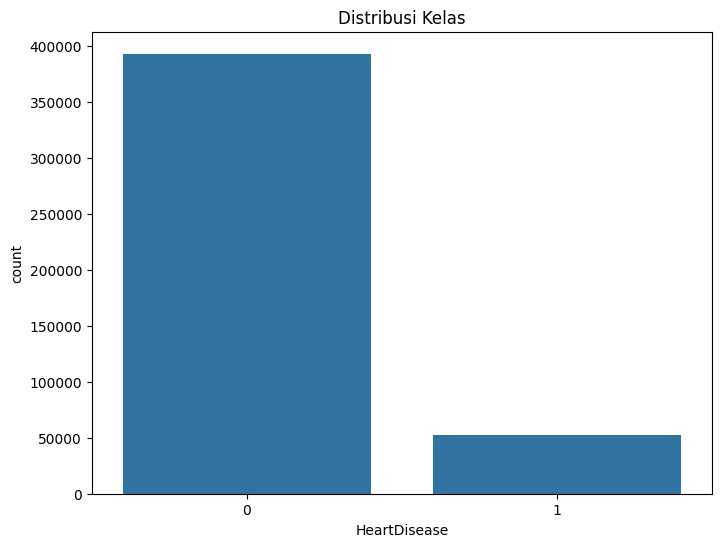


Akurasi Model:
0.8847238608910613

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     78544
           1       0.54      0.13      0.21     10451

    accuracy                           0.88     88995
   macro avg       0.72      0.56      0.57     88995
weighted avg       0.85      0.88      0.85     88995


Matriks Konfusi:
[[77401  1143]
 [ 9116  1335]]


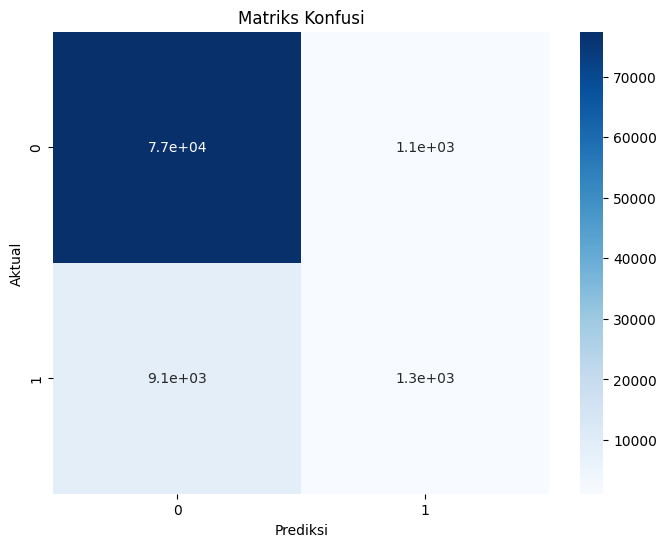

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# EDA
print("Informasi Data:")
print(df_prepared.info())
print("\nDeskripsi Data:")
print(df_prepared.describe())

# Cek distribusi kelas
print("\nDistribusi Kelas:")
print(df_prepared['HeartDisease'].value_counts())

# Visualisasi distribusi kelas
plt.figure(figsize=(8, 6))
sns.countplot(x='HeartDisease', data=df_prepared)
plt.title('Distribusi Kelas')
plt.show()

# Evaluasi model
y_pred = logreg_pipeline.predict(X_test)
print("\nAkurasi Model:")
print(accuracy_score(y_test, y_pred))
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred))
print("\nMatriks Konfusi:")
print(confusion_matrix(y_test, y_pred))

# Visualisasi matriks konfusi
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Matriks Konfusi')
plt.show()


In [48]:
#MENYIMPAN MODEL DALAM 3 FORMAT
# =================================================================================================
print("\n[INFO] Menyimpan model...")
export_dir = 'saved_model/'

# Use joblib to save the scikit-learn pipeline
# Ensure the directory exists
os.makedirs(export_dir, exist_ok=True)
joblib_model_path = os.path.join(export_dir, 'logreg_pipeline.joblib')
joblib.dump(logreg_pipeline, joblib_model_path)
print(f"[SUCCESS] Model disimpan dalam format Joblib ke: {joblib_model_path}")

# The following sections for TFLite and TensorFlow.js are commented out
# as they are not applicable to scikit-learn pipelines.

# print("\n[INFO] Mengkonversi model ke format TF-Lite...")
# converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
# tflite_model = converter.convert()
# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)
# print("[SUCCESS] Model dikonversi ke format TF-Lite.")

# print("\n[INFO] Mengkonversi model ke format TensorFlow.js...")
# # PERBAIKAN: Upgrade library 'packaging' untuk mengatasi dependency conflict
# !pip install --upgrade -q packaging

# # Install tensorflowjs setelah upgrade
# !pip install -q tensorflowjs
# !tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model {export_dir} tfjs_model/
# print("[SUCCESS] Model dikonversi ke format TensorFlow.js.")


[INFO] Menyimpan model...
[SUCCESS] Model disimpan dalam format Joblib ke: saved_model/logreg_pipeline.joblib


# Task
Implement a binary classification model using TensorFlow/Keras, including data preprocessing, training, evaluation, and export to a format compatible with TensorFlow.js.

## Adapt preprocessing for tensorflow/keras

### Subtask:
Translate the scikit-learn preprocessing steps (imputation, scaling, encoding, mapping) into a format compatible with TensorFlow/Keras.


**Reasoning**:
Define the columns based on the previous steps and separate the target variable.



In [49]:
numeric_cols = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms', 'BMI']
ordinal_cols = ['GeneralHealth', 'RemovedTeeth', 'SmokerStatus', 'ECigaretteUsage', 'AgeCategory']
binary_cols = ['IsMale', 'PhysicalActivities', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver']
nominal_cols = ['HadDiabetes', 'RaceEthnicityCategory', 'TetanusLast10Tdap', 'CovidPos']
target_col = 'HeartDisease'

X = df_prepared.drop(target_col, axis=1)
y = df_prepared[target_col]

In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate, StringLookup, CategoryEncoding, Normalization, Lambda
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.impute import SimpleImputer

# Split data for fitting the preprocessing layers
X_train, X_test, y_train, y_test = train_test_split(
    df_prepared.drop(target_col, axis=1), df_prepared[target_col],
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Define input layers for each feature
inputs = {}
for col in numeric_cols + ordinal_cols + binary_cols + nominal_cols:
    if df_prepared[col].dtype == 'object':
        inputs[col] = Input(shape=(1,), name=col, dtype=tf.string)
    else:
        inputs[col] = Input(shape=(1,), name=col, dtype=tf.float32)

# Preprocessing layers
preprocessed_outputs = []

# Numerical columns
for col in numeric_cols:
    # Impute numerical features using sklearn SimpleImputer
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = imputer.fit_transform(X_train[[col]])

    # Scale numerical features using Normalization layer
    scaler = Normalization(axis=None)
    scaler.adapt(X_train_imputed)
    preprocessed_outputs.append(scaler(inputs[col]))

# Ordinal columns
for col in ordinal_cols:
    # Impute ordinal features using sklearn SimpleImputer with most frequent strategy
    imputer = SimpleImputer(strategy='most_frequent')
    X_train_imputed = imputer.fit_transform(X_train[[col]].astype(str)).flatten() # Flatten for vocabulary

    # Define vocabulary based on imputed training data
    vocabulary = np.unique(X_train_imputed[X_train_imputed != None]).tolist() # Filter out None

    # Map strings to integers using StringLookup
    lookup = StringLookup(vocabulary=vocabulary, num_oov_indices=1, mask_token=None)
    mapped_values = lookup(inputs[col])
    # Cast to float using Lambda layer
    preprocessed_outputs.append(Lambda(lambda x: tf.cast(x, dtype=tf.float32))(mapped_values))


# Binary columns
for col in binary_cols:
    # Impute binary features using sklearn SimpleImputer with most frequent strategy
    imputer = SimpleImputer(strategy='most_frequent')
    X_train_imputed = imputer.fit_transform(X_train[[col]].astype(str)).flatten() # Flatten for vocabulary

    # Define vocabulary based on imputed training data
    vocabulary = np.unique(X_train_imputed[X_train_imputed != None]).tolist() # Filter out None

    # Map strings to integers using StringLookup
    lookup = StringLookup(vocabulary=vocabulary, num_oov_indices=1, mask_token=None)
    mapped_values = lookup(inputs[col])
    # Cast to float using Lambda layer
    preprocessed_outputs.append(Lambda(lambda x: tf.cast(x, dtype=tf.float32))(mapped_values))


# Nominal columns
for col in nominal_cols:
    # Impute nominal features with a constant value
    imputer = SimpleImputer(strategy='constant', fill_value='missing')
    X_train_imputed = imputer.fit_transform(X_train[[col]].astype(str)).flatten() # Flatten for vocabulary

    # Define vocabulary based on imputed training data
    vocabulary = np.unique(X_train_imputed[X_train_imputed != None]).tolist() # Filter out None

    # Map strings to integers using StringLookup and then one-hot encode
    string_lookup = StringLookup(vocabulary=vocabulary, num_oov_indices=1, mask_token=None)

    one_hot = CategoryEncoding(num_tokens=string_lookup.vocabulary_size(), output_mode="one_hot")
    encoded_output = one_hot(string_lookup(inputs[col]))
    preprocessed_outputs.append(encoded_output)

# Concatenate all preprocessed features
concatenated_features = concatenate(preprocessed_outputs)

# Create the preprocessing model
preprocessing_model = Model(inputs=inputs, outputs=concatenated_features)

# Display the model summary
preprocessing_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ GeneralHealth       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RemovedTeeth        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SmokerStatus        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ECigaretteUsage     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AgeCategory         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ IsMale (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PhysicalActivities  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HadAsthma           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HadSkinCancer       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HadCOPD             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HadDepressiveDisor… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HadKidneyDisease    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HadArthritis        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DeafOrHardOfHearing │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BlindOrVisionDiffi… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DifficultyConcentr… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DifficultyWalking   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                 

 Total params: 18 (96.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18 (96.00 B)

**Reasoning**:
The preprocessing model has been successfully created. The next step is to verify the output of the preprocessing model with sample data to ensure it produces the expected preprocessed features.



In [51]:
# Select a sample from the original prepared data
sample_input = X_test.sample(5)

# Convert the sample input to a dictionary of numpy arrays, matching the input layer names and dtypes
input_dict = {}
for col in sample_input.columns:
    if sample_input[col].dtype == 'object':
        # Handle potential NaN in object columns by converting to string and then to bytes
        input_dict[col] = sample_input[col].fillna('').astype(str).values.reshape(-1, 1).astype(str)
    else:
        input_dict[col] = sample_input[col].values.reshape(-1, 1).astype(np.float32)

# Get the preprocessed output from the model
preprocessed_output = preprocessing_model(input_dict)

# Print the preprocessed output (as a TensorFlow tensor)
print("Preprocessed Output:")
print(preprocessed_output)

Preprocessed Output:
tf.Tensor(
[[-0.49328107 -0.5162379  -0.01563801 -0.99020785 -0.43628666  0.07566431
   6.          3.          5.          3.         12.          1.
   3.          2.          2.          2.          2.          2.
   3.          2.          0.          2.          2.          2.
   2.          3.          2.          3.          2.          0.
   0.          0.          1.          0.          0.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.          1.          0.          0.          0.
   0.          0.          1.          0.          0.        ]
 [ 2.989382    3.088038   -2.0204847  -0.50750107 -0.08089747  0.22458567
   2.          2.          1.          3.          8.          1.
   2.          2.          2.          2.          2.          2.
   2.          2.          2.          3.          3.          3.
   3.          0.          2.          2.          2.          0.
   0.          0.          0.  

## Define and build a keras model

### Subtask:
Create a suitable Keras model architecture for binary classification. A simple sequential model with dense layers would be a good starting point.


**Reasoning**:
Define the Keras model architecture using the Functional API, starting with the output of the preprocessing_model, adding dense layers, and a final output layer for binary classification.



In [52]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model

# Get the output of the preprocessing model
preprocessed_input = preprocessing_model.output

# Add Dense layers
x = Dense(128, activation='relu')(preprocessed_input)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

# Add the output layer for binary classification
outputs = Dense(1, activation='sigmoid')(x)

# Create the full Keras model
model = Model(inputs=preprocessing_model.input, outputs=outputs)

# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ GeneralHealth       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RemovedTeeth        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SmokerStatus        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ECigaretteUsage     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AgeCategory         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ IsMale (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PhysicalActivities  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HadAsthma           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HadSkinCancer       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HadCOPD             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HadDepressiveDisor… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HadKidneyDisease    │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HadArthritis        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DeafOrHardOfHearing │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BlindOrVisionDiffi… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DifficultyConcentr… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DifficultyWalking   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                 

 Total params: 15,251 (59.60 KB)

 Trainable params: 15,233 (59.50 KB)

 Non-trainable params: 18 (96.00 B)

## Compile the keras model

### Subtask:
Configure the model for training by specifying an optimizer, loss function, and metrics.


**Reasoning**:
Import the necessary optimizer and metrics and compile the Keras model with the specified optimizer, loss function, and metrics.



In [53]:
import tensorflow as tf

# Configure the model for training
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()]
)

print("Model compiled successfully.")

Model compiled successfully.


## Train the keras model

### Subtask:
Train the Keras model using your prepared data. You might need to adjust the training process to handle the class imbalance, similar to what you might do with scikit-learn (e.g., using class weights).


In [54]:
import numpy as np
import tensorflow as tf

# 1. Calculate class weights (Already calculated in previous steps)
neg, pos = np.bincount(y_train)
total = neg + pos
print(f'Total samples: {total}')
print(f'Positive samples: {pos} ({100 * pos / total:.2f}% of total)')
print(f'Negative samples: {neg} ({100 * neg / total:.2f}% of total)')

# Calculate class weights
weight_for_0 = (total / (2 * neg))
weight_for_1 = (total / (2 * pos))

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f'Weight for class 0: {weight_for_0:.2f}')
print(f'Weight for class 1: {weight_for_1:.2f}')

# 2. Convert data to TensorFlow Datasets
# Helper function to convert dataframe to dictionary of tensors
def df_to_dataset(dataframe, labels=None):
    dataframe = dataframe.copy()
    # Convert object columns to string explicitly
    for col in dataframe.select_dtypes(include='object').columns:
        dataframe[col] = dataframe[col].astype(str)
    if labels is not None:
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    else:
        ds = tf.data.Dataset.from_tensor_slices(dict(dataframe))
    return ds

# Create TensorFlow Datasets
train_ds = df_to_dataset(X_train, y_train)
test_ds = df_to_dataset(X_test, y_test)

# Configure datasets for performance
BATCH_SIZE = 32
# Use a fixed buffer size for shuffle, for example, the size of the training data
SHUFFLE_BUFFER_SIZE = len(X_train)
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE


train_ds = train_ds.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
test_ds = test_ds.batch(BATCH_SIZE).cache().prefetch(buffer_size=PREFETCH_BUFFER_SIZE)


# 3. Train the compiled Keras model
EPOCHS = 10 # You can adjust the number of epochs

print("\nTraining the model...")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    class_weight=class_weight
)

# 4. Store the training history
# The history object is already stored in the 'history' variable
print("\nModel training complete. Training history stored.")

Total samples: 355980
Positive samples: 41804 (11.74% of total)
Negative samples: 314176 (88.26% of total)
Weight for class 0: 0.57
Weight for class 1: 4.26

Training the model...
Epoch 1/10
11125/11125 ━━━━━━━━━━━━━━━━━━━━ 111s 9ms/step - auc: 0.5002 - binary_accuracy: 0.8825 - loss: nan - val_auc: 0.5000 - val_binary_accuracy: 0.8826 - val_loss: nan
Epoch 2/10
11125/11125 ━━━━━━━━━━━━━━━━━━━━ 102s 9ms/step - auc: 0.5000 - binary_accuracy: 0.8829 - loss: nan - val_auc: 0.5000 - val_binary_accuracy: 0.8826 - val_loss: nan
Epoch 3/10
11125/11125 ━━━━━━━━━━━━━━━━━━━━ 101s 9ms/step - auc: 0.5000 - binary_accuracy: 0.8829 - loss: nan - val_auc: 0.5000 - val_binary_accuracy: 0.8826 - val_loss: nan
Epoch 4/10
11125/11125 ━━━━━━━━━━━━━━━━━━━━ 98s 9ms/step - auc: 0.5000 - binary_accuracy: 0.8829 - loss: nan - val_auc: 0.5000 - val_binary_accuracy: 0.8826 - val_loss: nan
Epoch 5/10
11125/11125 ━━━━━━━━━━━━━━━━━━━━ 98s 9ms/step - auc: 0.5000 - binary_accuracy: 0.8829 - loss: nan - val_auc: 0.500

## Evaluate the keras model

### Subtask:
Evaluate the performance of the trained Keras model using appropriate metrics.

In [55]:
# Evaluate the model on the test set
loss, accuracy, auc = model.evaluate(test_ds)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")

2782/2782 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - auc: 0.5000 - binary_accuracy: 0.8807 - loss: nan
Test Loss: nan
Test Accuracy: 0.8826
Test AUC: 0.5000


## Convert the model to TensorFlow.js

### Subtask:
Use the TensorFlow.js converter tool to convert the SavedModel into a web-friendly format.

In [56]:
# Install TensorFlow.js converter
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.10.1 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [57]:
# Convert the SavedModel to TensorFlow.js format
!tensorflowjs_converter \
  --input_format=tf_saved_model \
  --output_format=tfjs_graph_model \
  --output_node_names='sequential/dense_2/Sigmoid' \
  keras_saved_model \
  tfjs_model

2025-10-11 15:24:04.772666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760196244.806892    7458 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760196244.817198    7458 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760196244.842246    7458 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760196244.842294    7458 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760196244.842304    7458 computation_placer.cc:177] computation placer alr

## Export the keras model

### Subtask:
Save the trained Keras model in a format that can be converted to TensorFlow.js (e.g., SavedModel format).

In [58]:
import os

# Define the directory to save the model
keras_model_path = 'keras_saved_model'

# Save the model in the TensorFlow SavedModel format
model.export(keras_model_path)

print(f"Keras model saved to: {keras_model_path}")

Saved artifact at 'keras_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): Dict[['PhysicalHealthDays', TensorSpec(shape=(None, 1), dtype=tf.float32, name='PhysicalHealthDays')], ['MentalHealthDays', TensorSpec(shape=(None, 1), dtype=tf.float32, name='MentalHealthDays')], ['SleepHours', TensorSpec(shape=(None, 1), dtype=tf.float32, name='SleepHours')], ['HeightInMeters', TensorSpec(shape=(None, 1), dtype=tf.float32, name='HeightInMeters')], ['WeightInKilograms', TensorSpec(shape=(None, 1), dtype=tf.float32, name='WeightInKilograms')], ['BMI', TensorSpec(shape=(None, 1), dtype=tf.float32, name='BMI')], ['GeneralHealth', TensorSpec(shape=(None, 1), dtype=tf.string, name='GeneralHealth')], ['RemovedTeeth', TensorSpec(shape=(None, 1), dtype=tf.string, name='RemovedTeeth')], ['SmokerStatus', TensorSpec(shape=(None, 1), dtype=tf.string, name='SmokerStatus')], ['ECigaretteUsage', TensorSpec(shape=(None, 1), dtype=tf.string, name='ECigaretteUsa